# LTV LQR

This notebook shows sample application of LTV LQR for trajectory following. 

The notebook contains:
1. Fitting the trajectory based on kinematic constraints
2. Trajectory interpolation, estimating desired acceleration
3. Designing the controller

In [1]:
import numpy as np 
from darli.models import RobotModel
import mujoco
import mediapy as media
import casadi as cs
from matplotlib import pyplot as plt

%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


## Part 1. Trajectory

In [2]:
urdf_file = '../yet_another_menagerie/z1/z1.urdf'
model = RobotModel(urdf_file, bodies_names={'ee': 'link06'})

In [3]:
nq, nv, nu = model.nq, model.nv, model.nu

Let's create some parametric trajectory. It might be chosed arbitrary and parametrically. Notably, it does not has to be completely feasible.

Let's design the sinusoidal closed trajectory:

In [4]:
t_end = 10
dt_route = 1e-1
l = 0.2
z0 = 0.4
ts = np.arange(0, t_end, dt_route)
ee_traj = np.vstack([
    l * np.cos(ts),
    l * np.sin(ts),
    z0 + 0.1*np.sin(5*ts)
])

ee_traj.shape

(3, 100)

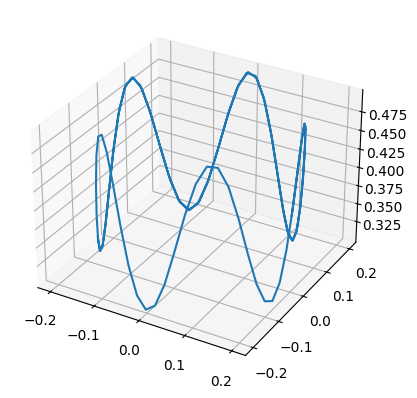

In [5]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(ee_traj[0], ee_traj[1], ee_traj[2])

plt.show()

Now, let's find the generalized coordinates for each of the positions. To avoid huge discontinuities in coordinates, let's introduce the restrictions on the joint velocities.

In [ ]:
opti_problem = cs.Opti()
q = opti_problem.variable(nq, len(ts))
dq = opti_problem.variable(nv, len(ts))

In [7]:
positions = model.body('ee').position(q)

In [8]:
desired_positions = opti_problem.parameter(3, len(ts))

In [9]:
dq_min = -np.pi*np.ones(nq)
dq_max = np.pi*np.ones(nq)

In [10]:
cost = cs.sumsqr(positions - desired_positions)
opti_problem.minimize(cost)

for i in range(len(ts)-1):
    # Velocity constraints
    opti_problem.subject_to(dq[:, i+1] == (q[:, i+1] - q[:, i])/dt_route)
    opti_problem.subject_to(opti_problem.bounded(dq_min, dq[:, i+1], dq_max))

# Positional constraints of the manipulator
opti_problem.subject_to(opti_problem.bounded(model.q_min, q, model.q_max))
opti_problem.subject_to(dq[:, 0] == np.zeros(nq))
opti_problem.solver('ipopt')

In [11]:
opti_problem.set_value(desired_positions, ee_traj)

In [12]:
opti_problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1788
Number of nonzeros in inequality constraint Jacobian.:     1194
Number of nonzeros in Lagrangian Hessian.............:     1500

Total number of variables............................:     1200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 2 (nx = 1200)
  #parameters: 1 (np = 300)
  #constraints: 200 (ng = 1794)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [13]:
q_values = opti_problem.value(q).T
dq_values = opti_problem.value(dq).T
q_values.shape

(100, 6)

Now, let's visualize the resulting positions

In [14]:
mj_model = mujoco.MjModel.from_xml_path("../yet_another_menagerie/z1/scene.xml")
data = mujoco.MjData(mj_model)
mj_model.opt.timestep = dt_route

renderer = mujoco.Renderer(mj_model)
scene_option = mujoco.MjvOption()

""

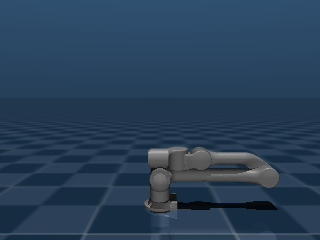

In [15]:
mujoco.mj_forward(mj_model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [16]:
duration = 10  # (seconds)
framerate = 10 # used just for visualization

# Simulate and display video.
frames = []
mujoco.mj_resetData(mj_model, data)  # Reset state and time.

data.qpos = q_values[0]

state_history = []
control_history = []
error_history = []

for i in range(len(ts)):
    data.qpos = q_values[i]
    mujoco.mj_step(mj_model, data)

    if len(frames) < i * dt_route * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)
    
media.show_video(frames, fps=framerate)

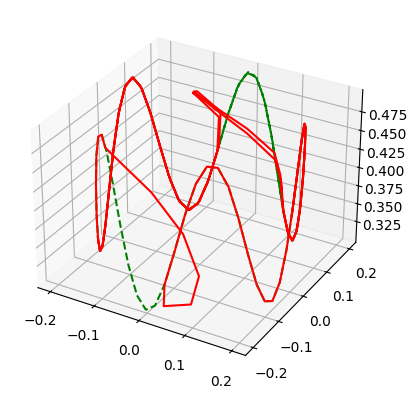

In [17]:
res_positions = model.body('ee').position(q_values.T).toarray()
ax = plt.figure().add_subplot(projection='3d')

ax.plot(ee_traj[0], ee_traj[1], ee_traj[2], '--', color='green')
ax.plot(res_positions[0], res_positions[1], res_positions[2], color='red')

plt.show()

As you can see, the trajectory could not be matched completely, however, it converged as much as it could

## Data interpolation & desired acceleration

The discretization of the trajectory was only 10Hz, which might not be enough for good controller performance. Hence, let's create trajectory interpolation, and sample it with higher rate

In [19]:
q_interpolants = [cs.interpolant("LUT", "bspline", [ts], q_values[:, i]) for i in range(nq)]
q_interpolation = lambda t: np.array([q_interpolants[i](t) for i in range(nq)]).reshape(nq, -1)

In [20]:
dq_interpolants = [cs.interpolant("LUT", "bspline", [ts], dq_values[:, i]) for i in range(nq)]
dq_interpolation = lambda t: np.array([dq_interpolants[i](t) for i in range(nq)]).reshape(nq, -1)

To estimate control (we'll see why we need that soon), one would need to solve inverse dynamics problem, for which we would need to know desired accelerations. Let's estimate them:

In [24]:
ddq = []
for i in range(len(ts)):
    ddq.append((dq_values[(i+1)%len(ts)] - dq_values[i])/dt_route)
ddq = np.array(ddq)

and interpolate:

In [25]:
ddq_interpolants = [cs.interpolant("LUT", "bspline", [ts], ddq[:, i]) for i in range(nq)]
ddq_interpolation = lambda t: np.array([ddq_interpolants[i](t) for i in range(nq)]).reshape(nq, -1)

In [26]:
dt_control = 1e-2
t_end = 2*np.pi
ts = np.arange(0, t_end, dt_control)

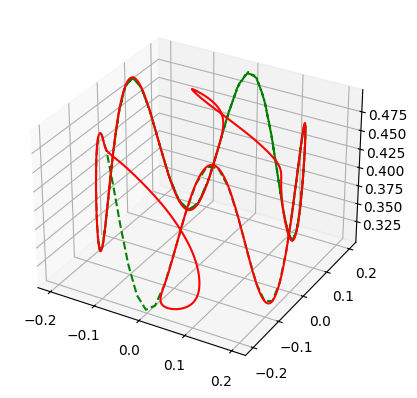

In [27]:

res_positions = model.body('ee').position(q_interpolation(ts)).toarray()
ax = plt.figure().add_subplot(projection='3d')

ax.plot(ee_traj[0], ee_traj[1], ee_traj[2], '--', color='green')
ax.plot(res_positions[0], res_positions[1], res_positions[2], color='red')

plt.show()

## Part 3. LTV LQR design

In [28]:
Q = np.eye(nq+nv)
R = np.eye(nu)*0.01

In [ ]:
P_gains = []
K_gains = []
q_traj = []
dq_traj = []
u_traj = []
P_cur = Q
for i in range(len(ts)-1, -1, -1):
    # Get current desired system state
    q_i = q_interpolation(ts[i])
    dq_i = dq_interpolation(ts[i])
    ddq_i = ddq_interpolation(ts[i])
    # Solving inverse dynamics problem to obtain u
    u_i = model.inverse_dynamics(q_i, dq_i, ddq_i).toarray()
    
    q_traj = [q_i] + q_traj
    dq_traj = [dq_i] + dq_traj
    u_traj = [u_i] + u_traj
    
    # Model linearization, requires to know control in general case
    A_i = model.state_space.state_jacobian([*q_i, *dq_i], u_i)
    B_i = model.state_space.input_jacobian([*q_i, *dq_i], u_i)
    
    # Model discretization
    Ad, Bd = np.eye(model.nq + model.nv) + dt_route*A_i, dt_route*B_i

    # Saving P gain
    P_gains = [P_cur] + P_gains
    
    # Recalculating the terms
    K_cur = cs.inv(R + Bd.T @ P_cur @ Bd) @ Bd.T @ P_cur @ Ad
    P_cur = Q + K_cur.T @ R @ K_cur + (Ad - Bd @ K_cur).T @ P_cur @ (Ad - Bd @ K_cur)

    # Saving K gain
    K_gains = [K_cur] + K_gains

In [30]:
P_gains = np.array(P_gains)
K_gains = np.array(K_gains)
q_traj = np.array(q_traj)
dq_traj = np.array(dq_traj)
u_traj = np.array(u_traj)

Finally, let's simulate the manipulator with the LQR controller:

In [31]:
mj_model = mujoco.MjModel.from_xml_path("../yet_another_menagerie/z1/scene.xml")
data = mujoco.MjData(mj_model)
mj_model.opt.timestep = 1e-3

Note, that simulation runs 3 iterations of the whole trajectory, to validate that it loops correctly:

In [45]:
duration = 3*t_end  # (seconds)
framerate = 30 # used just for visualization

# Simulate and display video.
frames = []
mujoco.mj_resetData(mj_model, data)  # Reset state and time.

data.qpos = q_values[0] * 0.5

state_history = []
control_history = []
error_history = []

t_next = dt_control
time_idx = 0

while data.time < duration:
    q, dq = data.qpos.copy(), data.qvel.copy(),  
    state = np.hstack((q, dq))

    if data.time > t_next:
        t_next += dt_control
        time_idx = (time_idx + 1) % len(ts) 
    cur_K = K_gains[time_idx]
    cur_state_des = np.concatenate((q_traj[time_idx], dq_traj[time_idx])).ravel()
    cur_u_des = u_traj[time_idx].ravel()
    
    u =  - cur_K @ (state - cur_state_des) + cur_u_des
    data.ctrl = np.array(u).reshape(mj_model.nu, )
    state_history.append(state)
    error_history.append(state - cur_state_des)
    control_history.append(data.ctrl.copy())    

    mujoco.mj_step(mj_model, data)

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)
    
media.show_video(frames, fps=framerate)

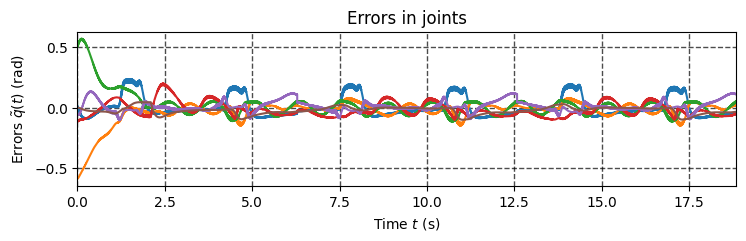

In [46]:
ns = len(state_history)
t = np.linspace(0, duration, ns)

plt.figure(figsize=(8.5, 2.))
plt.title(r'Errors in joints')
plt.plot(t, np.array(error_history)[:,:6])#,'r', linewidth=2.0)
plt.xlim([0, duration])
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'Errors $\tilde{q}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

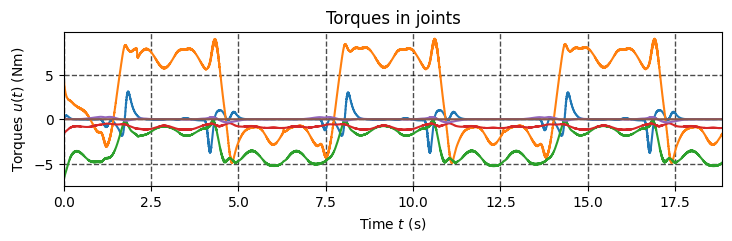

In [47]:
plt.figure(figsize=(8.5, 2.))
plt.title(r'Torques in joints')
plt.plot(t, np.array(control_history))#,'r', linewidth=2.0)
plt.xlim([0, duration])
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'Torques $u(t)$ (Nm)')
plt.xlabel(r'Time $t$ (s)')
plt.show()